<a href="https://colab.research.google.com/github/kfahn22/marbling/blob/main/marblingpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mathematical Marbling

* [marblingpy](https://github.com/taktpixel/marblingpy)

* [The Mathematics of Marbling](https://people.csail.mit.edu/jaffer/Marbling/Mathematics)

* [Blog - digital marbling](https://blog.amandaghassaei.com/2022/10/25/digital-marbling/)

* [Dropping Paint](https://people.csail.mit.edu/jaffer/Marbling/Dropping-Paint)



In [ ]:
!git clone https://github.com/taktpixel/marblingpy.git
%cd marblingpy

Cloning into 'marblingpy'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 142 (delta 76), reused 107 (delta 48), pack-reused 0
Receiving objects: 100% (142/142), 52.65 KiB | 1017.00 KiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/marblingpy


In [ ]:
# marblingpy [-h] [--init INIT] [--save FILE] -m M [-W W] [-H H] [--seed SEED] [--count C]
#   -h, --help                     show this help message and exit
#   --version                      show program\'s version number and exit
#   --init INIT                    if given, the distortion will start based from the image (png) file
#   --save FILE                    write generating image to FILE
#   -m M, --method M               the tool function that applies to the image; I=ink-drop, T=tine-line.
#   -W W, --width W                the width in integer of generating image file (gif)
#   -H H, --height H               the height in integer of generating image file (gif)
#   --seed SEED                    input of an unsigned integer 0 or 2^32-1 to the algorithm that generates pseudo-random numbers throughout the program. the same seed produces the same result.
#   --interpolation INTERPOLATION  pixel filling interpolation type
#   --count C                      the total number of times that tool functions shall be applied to render an image
#   -v, --verbose                  show verbose message

[argparse](https://docs.python.org/3/howto/argparse.html)

Copied gen_marbling b/c there was an error installing dependencies (maybe version issues as numpy and opencv-python are preinstalled in colab??)

Run this cell first!

In [ ]:
import numpy as np
import cv2
import argparse
import os
import sys
import random
import datetime
import time
#from datetime import datetime
PACKAGE_NAME = 'marblingpy'
ELEMENT_TYPE = np.uint8

MIN_THRESHOLD = 1e-8



# import matplotlib.pyplot as plt
# from PIL import Image
#
# test functions
#
def testGetRandomIntDivision(n, div, divList = []):
    s = np.random.randint(0, n + 1)
    divList.append(s)

    if div - 2 <= 0:
        divList.append(n - s)
        return divList

    return testGetRandomIntDivision(n - s, div - 1, divList)

def testDropCircle(img, height, width, count = 10, interpolation = 'nearest', verbose = False):
    for i in range(count):
        color = np.random.randint(0, 256, 3)
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        r = np.random.randint(10, np.min((100, np.max((10, int(np.min((width, height))/2))))))

        if (verbose):
            print('drop circle ({}/{}) : (x, y, r) = ({}, {}, {})'.format(i, count, x, y, r))

        dropCircle(img, color, (y, x), r, interpolation)

def testDrawTineLine(img, height, width, count = 2, interpolation = 'nearest', verbose = False):
    for i in range(count):
        dir1 = np.random.randint(1, height)
        dir2 = np.random.randint(1, width)
        init1 = np.random.randint(0, height)
        init2 = np.random.randint(0, width)
        shift = np.random.randint(0, np.min((width, height)) * 2)
        sharpness = np.random.randint(0, 32)

        if (verbose):
            print('tine line ({}/{}) : (x1, y1), (x2, y2), shift, sharpness = ({}, {}), ({}, {}), {}, {}' \
                    .format(i, count, dir1, dir2, init1, init2, shift, sharpness))

        drawTineLine(img, height, width, (dir1, dir2), (init1, init2), shift, sharpness, interpolation)

#
# utilities
#
def range2dCoord(width, height):
    """get range for 2D iteration

    Args:
        width (int): image width
        height (int): image height

    Returns:
        2D array: shape is (width * height, 2)
    """
    baseArr = [[x for x in range(width)]] * height
    xArr = np.stack(baseArr, axis=0).reshape((height * width,))
    yArr = np.stack(baseArr, axis=1).reshape((height * width,))
    sourceCoord = np.column_stack((xArr, yArr))
    return sourceCoord

def bilinearInterpolation(img, x, y):
    """pickup bilinear interpolated color

    Args:
        img (Mat): 3D, 3-channel color image
        x (float): floating position coordinate
        y (float): floating position coordinate

    Returns:
        value: color value
    """
    x1 = np.floor(x).astype(ELEMENT_TYPE)
    x2 = x1 + 1
    xr = x - x1
    y1 = np.floor(y).astype(ELEMENT_TYPE)
    y2 = y1 + 1
    yr = y - y1

    channel = img.shape[2]
    val = np.zeros((channel))

    xx = np.array([[1 - xr], [xr]], dtype='float32')
    yy = np.array([[1 - yr], [yr]], dtype='float32')
    f = np.array([[img[int(x1), int(y1), :], img[int(x1), int(y2), :]], [img[int(x2), int(y1), :], img[int(x2), int(y2), :]]])

    for i in range(channel):
        b = np.matmul(f[:, :, i], yy)
        v = np.matmul(xx.T, b)
        val[i] = v

    return np.around(np.array(val)).astype(ELEMENT_TYPE).reshape(channel)


#
# tool functions
#
def dropCircle(img, color, dpCoord, r, interpolation = 'nearest'):
    dpCoord = np.array(dpCoord)

    # prepare source coordinate
    h, w, _ = img.shape
    sourceCoord = range2dCoord(w, h)

    # generate pickup coordinate
    derivCoordArray = sourceCoord - dpCoord
    r_2 = r**2
    dArray_2 = np.maximum(np.power(np.linalg.norm(derivCoordArray, axis=1), 2), MIN_THRESHOLD)
    factorArray = np.sqrt(np.maximum((dArray_2 - r_2) / dArray_2, MIN_THRESHOLD))
    pickupCoord = dpCoord + np.multiply(derivCoordArray, factorArray.reshape((1, -1)).T)

    # extract
    outerIndex = np.where(dArray_2 > r_2)
    sourceCoord = sourceCoord[outerIndex]
    pickupCoord = pickupCoord[outerIndex]

    if interpolation == 'nearest':
        # for nearest neighbor
        pickupCoord = np.round(pickupCoord).astype(ELEMENT_TYPE)

        # copy spreading pixel by nearest neighbor
        img[sourceCoord[:, 0], sourceCoord[:, 1], :] = img[pickupCoord[:, 0], pickupCoord[:, 1], :]
    elif interpolation == 'bilinear':
        buf = img.copy()
        for idx in range(len(sourceCoord)):
            p = sourceCoord[idx]
            q = pickupCoord[idx]
            img[p[0], p[1], :] = bilinearInterpolation(buf, q[0], q[1])

    # cv2.circle method specifies the dropping point reverse the order (y, x)
    # instead of (x, y)
    if isinstance(color, np.ndarray):
        _color = color.tolist()
    else:
        _color = color
    # LINE_8
    #cv2.circle(img, (dpCoord[1], dpCoord[0]), r, _color, -1, lineType=cv2.LINE_AA)
    cv2.circle(img, (dpCoord[1], dpCoord[0]), r, _color, -1, lineType=cv2.LINE_8)



def drawTineLine(img, height, width, dirVector, initCoord = (0, 0), shift = 10, sharpness = 2, interpolation = 'nearest'):
    # setup variables
    initCoordArray = np.array(initCoord)

    ## dirVector must not be zero vector (i.e. !=(0,0) )
    ## because the y-axis is inverted within the pixel coordinate, y-coordinate must be multiplied by -1.
    dirVectorArray = np.array((dirVector[0], -dirVector[1]))
    normOfDirVector = np.linalg.norm(dirVectorArray)

    if normOfDirVector == 0:
        raise RuntimeError('"dirVector" must not be zero vector.')

    dirVectorUnitArray = dirVectorArray / normOfDirVector

    ## the y-axis inversion makes the normal vector be equivalent of directional vector of the tine line,
    ## if the orientation is compatible with given arguments, which suffices in this case.
    nCoordArray = np.array(dirVector)
    nCoordUnitArray = nCoordArray / np.linalg.norm(nCoordArray)

    # prepare source coordinate
    h, w, _ = img.shape
    sourceCoord = range2dCoord(w, h)

    # calculate the distance between a point and the tine line
    # note how we calculate the norm of inner product
    sourceCoordSub = np.subtract(sourceCoord, initCoordArray.reshape(-1, 1).T)
    nCoordUnitArrayMul = np.multiply(sourceCoordSub, nCoordUnitArray.reshape(-1, 1).T)
    dArray = np.abs(nCoordUnitArrayMul.sum(axis=1))
    dArray = np.maximum(dArray, MIN_THRESHOLD)

    # calculate the reverse function in order to obtain the originated point to be applied the tool function.
    reverseFactor = shift * sharpness / (dArray + sharpness)
    pickupCoord = sourceCoord - np.multiply(reverseFactor.reshape(-1, 1), dirVectorUnitArray.reshape(-1 , 1).T)
    pickupCoord = np.clip(pickupCoord, (0, 0), (width -1, height - 1))

    if interpolation == 'nearest':
        # for nearest neighbor
        pickupCoord = np.round(pickupCoord).astype(ELEMENT_TYPE)

        # copy spreading pixel by nearest neighbor
        img[sourceCoord[:, 0], sourceCoord[:, 1], :] = img[pickupCoord[:, 0], pickupCoord[:, 1], :]
    elif interpolation == 'bilinear':
        buf = img.copy()
        for idx in range(len(sourceCoord)):
            p = sourceCoord[idx]
            q = pickupCoord[idx]
            img[p[0], p[1], :] = bilinearInterpolation(buf, q[0], q[1])

def main():
    NOW = datetime.datetime.utcnow()
    parser = argparse.ArgumentParser(prog=PACKAGE_NAME.replace('_', '-'), description='generate a randomized mathematical marbling image.')
    #parser.add_argument('--version', action='version', version='%(prog)s ' + __version__)
    parser.add_argument('--init', dest='INIT', type=str, help='if given, the distortion will start based from the image (png) file', metavar='INIT')
    parser.add_argument('--save', dest='FILE', type=str, help='write generating image to FILE', metavar='FILE', default=NOW.strftime('%y%m%d%H%M%S.%f')[:-3] + '.png')
    parser.add_argument('-m', '--method', dest='METHOD', type=str, help='the tool function that applies to the image; I=ink-drop, T=tine-line.', metavar='M', choices=['I', 'T'], required=True)
    parser.add_argument('-W', '--width', dest='WIDTH', type=int, help='the width in integer of generating image file (gif)', metavar='W', default=112)
    parser.add_argument('-H', '--height', dest='HEIGHT', type=int, help='the height in integer of generating image file (gif)', metavar='H', default=112)
    parser.add_argument('--seed', dest='SEED', type=np.uint32, help='input of an unsigned integer 0 or 2^32-1 to the algorithm that generates pseudo-random numbers throughout the program. the same seed produces the same result.', metavar='SEED', default=int(datetime.datetime.timestamp(NOW)))
    parser.add_argument('--interpolation', dest='INTERPOLATION', type=str, help='pixel filling interpolation type', metavar='INTERPOLATION', default='nearest', choices=['nearest', 'bilinear'])
    parser.add_argument('--count', dest='COUNT', type=int, help='the total number of times that tool functions shall be applied to render an image', metavar='C', default=1)
    parser.add_argument('-v', '--verbose', dest='VERBOSE', action='store_true', help='show verbose message')

    args = parser.parse_args()
    width = args.WIDTH
    height = args.HEIGHT

    # set seed
    np.random.seed(args.SEED)

    # show seed if verbose option is true
    if args.VERBOSE:
        print ('Current seed: %d' % args.SEED)

    # processing
    if args.INIT != None:
        imgLoaded = cv2.imread(args.INIT, cv2.IMREAD_UNCHANGED)
        orig2DShape = imgLoaded.shape[0:2]
        width = orig2DShape[1]
        height = orig2DShape[0]

        # linearly shrink/stretches the image range for uint16 data pallet
        img = cv2.normalize(imgLoaded, dst=None, alpha=0, beta=np.max(orig2DShape) - 1, norm_type=cv2.NORM_MINMAX)
    else:
        img = np.full((height, width, 3), 255, dtype=ELEMENT_TYPE)

    if args.METHOD == 'I':
        testDropCircle(img, height, width, args.COUNT, interpolation=args.INTERPOLATION, verbose=args.VERBOSE)
    elif args.METHOD == 'T':
        testDrawTineLine(img, height, width, args.COUNT, interpolation=args.INTERPOLATION, verbose=args.VERBOSE)

    # linearly stretches the image range for uint16 display pallet
    img_scaled = cv2.normalize(img, dst=None, alpha=0, beta=2**16 - 1, norm_type=cv2.NORM_MINMAX)
    cv2.imwrite(args.FILE, img_scaled)

# if __name__=='__main__':
#     main()


In [ ]:
width = 256
height = 256
color = np.random.randint(0, 256, 3)
x = np.random.randint(0, width)
y = np.random.randint(0, height)
r = np.random.randint(10, np.min((100, np.max((10, int(np.min((width, height))/2))))))

The error occurs because the img argument is a string representing the image path instead of the actual image data. To fix this, you need to load the image using cv2.imread before calling the testDropCircle function.

Test the function

In [ ]:
# import numpy as np

# img = np.zeros((height, width, 3), dtype=np.uint8)

In [ ]:
#testDropCircle(img, height, width, r)

In [ ]:
#testDrawTineLine(img, height, width, 2)

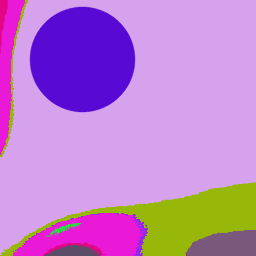

In [ ]:
# from google.colab.patches import cv2_imshow
# import cv2
# # Display the image
# cv2_imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [ ]:
import numpy as np
width = 256
height = 256
color = np.random.randint(0, 256, 3)
x = np.random.randint(0, width)
y = np.random.randint(0, height)
img = np.zeros((height, width, 3), dtype=np.uint8)
r = np.random.randint(10, np.min((100, np.max((10, int(np.min((width, height))/2))))))

In [ ]:
dropCircle(img, color, (x,y), r)
dropCircle(img, np.random.randint(0, 256, 3), (np.random.randint(0, width), np.random.randint(0, height)), r)
dropCircle(img, np.random.randint(0, 256, 3), (np.random.randint(0, width), np.random.randint(0, height)), r)
dropCircle(img, np.random.randint(0, 256, 3), (np.random.randint(0, width), np.random.randint(0, height)), r)

In [ ]:
def marble(img, count):
  for i in range(count):
     dropCircle(img, np.random.randint(0, 256, 3), (np.random.randint(0, width), np.random.randint(0, height)), np.random.randint(10, np.min((100, np.max((10, int(np.min((width, height))/2)))))))

In [ ]:
marble(img, 100)

In [ ]:
dirVector = np.array([-1, 1])

In [ ]:
drawTineLine(img, height, width, dirVector, initCoord = (202, 44), shift = 54, sharpness=27, interpolation = 'nearest')
drawTineLine(img, height, width, dirVector, initCoord = (23, 245), shift = 146, sharpness=28, interpolation = 'nearest')
drawTineLine(img, height, width, dirVector, initCoord = (25,23), shift = 66, sharpness=7, interpolation = 'nearest')

In [ ]:
# tine line (0/3) : (x1, y1), (x2, y2), shift, sharpness = (202, 44), (62, 177), 54, 27
# tine line (1/3) : (x1, y1), (x2, y2), shift, sharpness = (23, 245), (76, 234), 146, 28
# tine line (2/3) : (x1, y1), (x2, y2), shift, sharpness = (25, 23), (12, 127), 66, 7

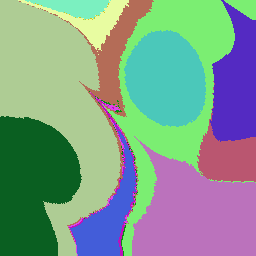

In [ ]:

import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# !marblingpy --save output.png --method I --width 256 --height 256 --count 10 --verbose
# #Current seed: 1602334135
# drop circle (0/10) : (x, y, r) = (194, 224, 52)
# drop circle (1/10) : (x, y, r) = (147, 165, 86)
# drop circle (2/10) : (x, y, r) = (184, 9, 42)
# drop circle (3/10) : (x, y, r) = (98, 245, 58)
# drop circle (4/10) : (x, y, r) = (155, 26, 30)
# drop circle (5/10) : (x, y, r) = (195, 95, 10)
# drop circle (6/10) : (x, y, r) = (185, 37, 87)
# drop circle (7/10) : (x, y, r) = (82, 215, 70)
# drop circle (8/10) : (x, y, r) = (233, 123, 29)
# drop circle (9/10) : (x, y, r) = (51, 186, 41)

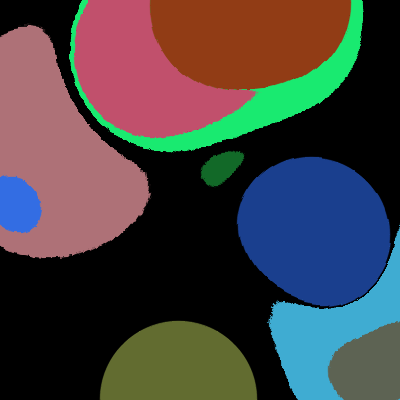

In [ ]:
# import numpy as np
# import cv2
# from google.colab.patches import cv2_imshow

# def testDropCircle(img, count=10, interpolation='nearest', verbose=False):
#     height, width, _ = img.shape
#     for i in range(count):
#         color = np.random.randint(0, 256, 3)
#         x = np.random.randint(0, width)
#         y = np.random.randint(0, height)
#         r = np.random.randint(10, min(100, max(10, int(min(width, height) / 2))))

#         if (verbose):
#             print('drop circle ({}/{}) : (x, y, r) = ({}, {}, {})'.format(i, count, x, y, r))

#         dropCircle(img, color, (x, y), r, interpolation)

# def dropCircle(img, color, dpCoord, r, interpolation = 'nearest'):
#     dpCoord = np.array(dpCoord)

#     # prepare source coordinate
#     h, w, _ = img.shape
#     sourceCoord = range2dCoord(w, h)

#     # generate pickup coordinate
#     derivCoordArray = sourceCoord - dpCoord
#     r_2 = r**2
#     dArray_2 = np.maximum(np.power(np.linalg.norm(derivCoordArray, axis=1), 2), MIN_THRESHOLD)
#     factorArray = np.sqrt(np.maximum((dArray_2 - r_2) / dArray_2, MIN_THRESHOLD))
#     pickupCoord = dpCoord + np.multiply(derivCoordArray, factorArray.reshape((1, -1)).T)

#     # extract
#     outerIndex = np.where(dArray_2 > r_2)
#     sourceCoord = sourceCoord[outerIndex]
#     pickupCoord = pickupCoord[outerIndex]

#     if interpolation == 'nearest':
#         # for nearest neighbor
#         pickupCoord = np.round(pickupCoord).astype(ELEMENT_TYPE)

#         # copy spreading pixel by nearest neighbor
#         img[sourceCoord[:, 0], sourceCoord[:, 1], :] = img[pickupCoord[:, 0], pickupCoord[:, 1], :]
#     elif interpolation == 'bilinear':
#         buf = img.copy()
#         for idx in range(len(sourceCoord)):
#             p = sourceCoord[idx]
#             q = pickupCoord[idx]
#             img[p[0], p[1], :] = bilinearInterpolation(buf, q[0], q[1])

#     # cv2.circle method specifies the dropping point reverse the order (y, x)
#     # instead of (x, y)
#     if isinstance(color, np.ndarray):
#         _color = color.tolist()
#     else:
#         _color = color

#     cv2.circle(img, (dpCoord[1], dpCoord[0]), r, _color, -1, lineType=cv2.LINE_AA)

# # Create a blank image
# height = 400
# width = 400
# img = np.zeros((height, width, 3), dtype=np.uint8)

# # Add circles to the image
# testDropCircle(img)

# # Display the image
# cv2_imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
